In [180]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [181]:
borrower_table = pd.read_csv('./borrower_table.csv')
loan_table = pd.read_csv('./loan_table.csv',parse_dates=['date'])

In [182]:
borrower_table.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [183]:
borrower_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
loan_id                                            101100 non-null int64
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null float64
currently_repaying_other_loans                     46153 non-null float64
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null int64
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
dtypes: fl

In [184]:
loan_table.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [185]:
loan_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
loan_id         101100 non-null int64
loan_purpose    101100 non-null object
date            101100 non-null datetime64[ns]
loan_granted    101100 non-null int64
loan_repaid     47654 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


# Data Processing

In [186]:
data = borrower_table.merge(loan_table,left_on='loan_id', right_on='loan_id')

In [187]:
# choose data with loan granted 
# the data with loan not granted is not useful for profit calculation
data = data[data['loan_granted']==1]
data.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1,1.0
5,423171,1,NaN,NaN,6100,0.53,6163,5298,1,29500,24,1,other,2012-11-07,1,1.0
7,200139,1,NaN,NaN,4000,0.57,602,2757,1,31700,36,8,business,2012-09-19,1,0.0
8,991294,0,1.0,0.0,7000,0.52,2575,2917,1,58900,33,3,emergency_funds,2012-12-04,1,1.0
9,875332,0,1.0,0.0,4300,0.83,722,892,1,5400,32,7,business,2012-01-20,1,1.0


In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 2 to 101099
Data columns (total 16 columns):
loan_id                                            47654 non-null int64
is_first_loan                                      47654 non-null int64
fully_repaid_previous_loans                        21865 non-null float64
currently_repaying_other_loans                     21865 non-null float64
total_credit_card_limit                            47654 non-null int64
avg_percentage_credit_card_limit_used_last_year    46751 non-null float64
saving_amount                                      47654 non-null int64
checking_amount                                    47654 non-null int64
is_employed                                        47654 non-null int64
yearly_salary                                      47654 non-null int64
age                                                47654 non-null int64
dependent_number                                   47654 non-null int64
loan_purpose        

In [189]:
# checking missing values
missing = data.isnull().sum()
missing[missing>0]

fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
avg_percentage_credit_card_limit_used_last_year      903
dtype: int64

In [190]:
# parse date information and extract month, week, and dayofweek information
data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

# drop useless features
data = data.drop(labels=['loan_id', 'date', 'loan_granted'], axis=1, inplace=False)

In [191]:
# there is a clear connection between 'is_first_loan' 
# and 'fully_repaid_previous_loans', 'currently_repaying_other_loans'
print(data[data['is_first_loan'] == 1]['fully_repaid_previous_loans'].unique())
print(data[data['is_first_loan'] == 1]['currently_repaying_other_loans'].unique())

[nan]
[nan]


In [192]:
# fill missing values with -1 for 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
data = data.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

In [193]:
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year':median})

In [194]:
# encoding 'loan_purpose'
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 2 to 101099
Data columns (total 16 columns):
is_first_loan                                      47654 non-null int64
fully_repaid_previous_loans                        47654 non-null float64
currently_repaying_other_loans                     47654 non-null float64
total_credit_card_limit                            47654 non-null int64
avg_percentage_credit_card_limit_used_last_year    47654 non-null float64
saving_amount                                      47654 non-null int64
checking_amount                                    47654 non-null int64
is_employed                                        47654 non-null int64
yearly_salary                                      47654 non-null int64
age                                                47654 non-null int64
dependent_number                                   47654 non-null int64
loan_purpose                                       47654 non-null int64
loan_repaid         

In [196]:
data.loan_repaid = data.loan_repaid.astype(int)

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 2 to 101099
Data columns (total 16 columns):
is_first_loan                                      47654 non-null int64
fully_repaid_previous_loans                        47654 non-null float64
currently_repaying_other_loans                     47654 non-null float64
total_credit_card_limit                            47654 non-null int64
avg_percentage_credit_card_limit_used_last_year    47654 non-null float64
saving_amount                                      47654 non-null int64
checking_amount                                    47654 non-null int64
is_employed                                        47654 non-null int64
yearly_salary                                      47654 non-null int64
age                                                47654 non-null int64
dependent_number                                   47654 non-null int64
loan_purpose                                       47654 non-null int64
loan_repaid         

In [198]:
from sklearn import preprocessing
datas = pd.DataFrame(preprocessing.scale(data))
datas.columns = list(data.columns)

In [199]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47654 entries, 0 to 47653
Data columns (total 16 columns):
is_first_loan                                      47654 non-null float64
fully_repaid_previous_loans                        47654 non-null float64
currently_repaying_other_loans                     47654 non-null float64
total_credit_card_limit                            47654 non-null float64
avg_percentage_credit_card_limit_used_last_year    47654 non-null float64
saving_amount                                      47654 non-null float64
checking_amount                                    47654 non-null float64
is_employed                                        47654 non-null float64
yearly_salary                                      47654 non-null float64
age                                                47654 non-null float64
dependent_number                                   47654 non-null float64
loan_purpose                                       47654 non-null float64
loa

In [200]:
datas.describe()

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,loan_repaid,month,week,dayofweek
count,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04,4.765400e+04
mean,-6.636550e-16,3.521686e-16,-6.231125e-16,7.054508e-18,5.798302e-16,-4.371326e-17,2.530234e-17,-1.498104e-16,4.153260e-17,-3.151685e-16,3.031947e-16,3.250697e-16,-1.165914e-15,-1.705383e-17,-9.372064e-17,-3.086761e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.086032e+00,-9.007716e-01,-8.304396e-01,-2.292458e+00,-3.977950e+00,-1.354208e+00,-1.623661e+00,-3.176486e+00,-1.795737e+00,-1.835361e+00,-1.431508e+00,-1.391814e+00,-1.346023e+00,-1.584354e+00,-1.689917e+00,-1.316684e+00
25%,-1.086032e+00,-9.007716e-01,-8.304396e-01,-7.229224e-01,-6.832469e-01,-7.421793e-01,-7.545619e-01,3.148133e-01,-6.352557e-01,-7.431006e-01,-6.685344e-01,-6.584006e-01,-1.346023e+00,-1.001667e+00,-8.900482e-01,-5.800038e-01
50%,9.207834e-01,-9.007716e-01,-8.304396e-01,-6.473001e-02,5.522101e-02,-3.142951e-01,-2.202493e-01,3.148133e-01,9.456271e-03,-4.093301e-02,-2.870477e-01,7.501272e-02,7.429295e-01,-1.276363e-01,-2.352406e-02,1.566763e-01
75%,9.207834e-01,1.163047e+00,5.642306e-01,6.440926e-01,7.368837e-01,5.729453e-01,6.230968e-01,3.148133e-01,6.725886e-01,6.612346e-01,8.574125e-01,8.084260e-01,7.429295e-01,7.463944e-01,8.430000e-01,8.933564e-01
max,9.207834e-01,1.163047e+00,1.958901e+00,4.542617e+00,2.213819e+00,5.771169e+00,4.485088e+00,3.148133e-01,4.172454e+00,2.923775e+00,1.620386e+00,1.541839e+00,7.429295e-01,1.620425e+00,1.709524e+00,1.630036e+00


In [201]:
datas['loan_repaid'] = data['loan_repaid'].values

In [202]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47654 entries, 0 to 47653
Data columns (total 16 columns):
is_first_loan                                      47654 non-null float64
fully_repaid_previous_loans                        47654 non-null float64
currently_repaying_other_loans                     47654 non-null float64
total_credit_card_limit                            47654 non-null float64
avg_percentage_credit_card_limit_used_last_year    47654 non-null float64
saving_amount                                      47654 non-null float64
checking_amount                                    47654 non-null float64
is_employed                                        47654 non-null float64
yearly_salary                                      47654 non-null float64
age                                                47654 non-null float64
dependent_number                                   47654 non-null float64
loan_purpose                                       47654 non-null float64
loa

In [203]:
# split into training and test data set
X = datas.drop('loan_repaid', axis=1)
y = datas['loan_repaid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [204]:
# Importing the model:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

# Initiating the model:
lr = LogisticRegression()

scores = cross_val_score(lr, X_train, y_train, scoring='accuracy' ,cv=10).mean()

print("The mean accuracy with 10 fold cross validation is %s" % round(scores*100,2))

The mean accuracy with 10 fold cross validation is 90.02


In [205]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [208]:
lr = lr.fit(X_train, y_train)
prob = lr.predict_proba(X_test)
predicted= lr.predict(X_test)

In [211]:
predicted

array([1, 0, 1, ..., 0, 1, 1])

In [213]:
prob[:,1]

array([0.99125433, 0.00842339, 0.99341446, ..., 0.06092095, 0.99504519,
       0.98499788])

In [221]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial').fit(X_train, y_train)
prob2 = lr.predict_proba(X_test)
predicted2= lr.predict(X_test)

In [217]:
# Total profit from original bank
loan_paid = y_test.astype(int).values
bank_profit = np.sum(loan_paid*2-1)
print('Bank profit:\t',bank_profit)

Bank profit:	 3440


In [218]:
# Now, let's set a series of threshold to determine whether or not the loan will be given
def calculate_profit(loan_paid, probability, threshold):
    loan_granted = (probability > threshold).astype(int)
    profit = 0
    for i in range(len(loan_paid)):
        if loan_granted[i] == 1:
            if loan_paid[i] == 0:
                profit -= 1
            else:
                profit += 1
                
    return profit

In [222]:
# calculate the profit according to given threshold
thresholds = list(np.linspace(0, 1, 100))
profits = []
profits2 = []

for threshold in thresholds:
    profits.append(calculate_profit(loan_paid, prob[:,1], threshold))
    profits2.append(calculate_profit(loan_paid, prob2[:,1], threshold))

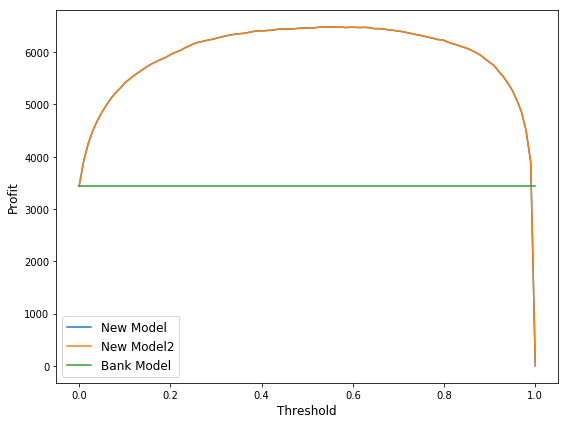

In [223]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, profits, label='New Model')
ax.plot(thresholds, profits2, label='New Model2')
ax.plot(thresholds, [bank_profit] * len(thresholds), label='Bank Model')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
